## 라이브러리 불러오기

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np    # 선형 대수 지원 라이브러리
import pandas as pd   # 데이터 처리, CSV 파일 I/O(예: pd.read_csv)
import os

## 데이터 전 처리

### 이미지 읽기

In [2]:
labels = ['O', 'R']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        print(path)
        class_num = labels.index(label)
#         print(class_num)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # 원하는 크기로 이미지 크기 변경
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('./DATASET/train')
test = get_training_data('./DATASET/test')

./DATASET/train\O
./DATASET/train\R


C:\Users\user\AppData\Local\Temp\ipykernel_9852\1125947815.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


./DATASET/test\O
./DATASET/test\R


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

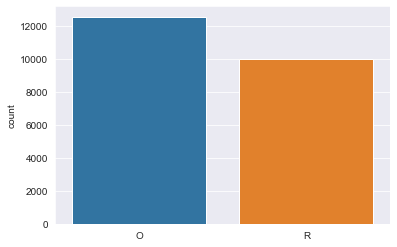

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("O")
    else:
        l.append("R")
        
sns.set_style('darkgrid')
sns.countplot(l)        

print(l)

Text(0.5, 1.0, 'R')

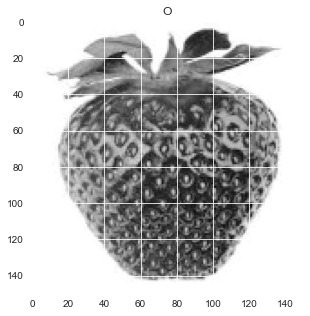

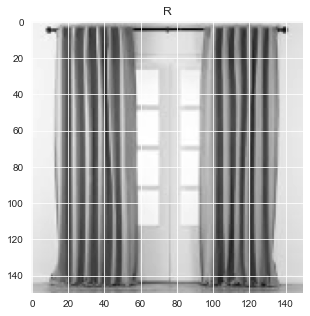

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [7]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_train.shape

(22564, 150, 150)

In [8]:
# 딥 러닝을 위한 데이터 크기 조정
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_train.shape

(22564, 150, 150, 1)

In [9]:
# 과적합을 방지하고 데이터 세트의 불균형을 처리하기 위한 데이터 확대

datagen = ImageDataGenerator(
        featurewise_center=False,              # 데이터셋에 대해 입력 평균을 0으로 설정
        samplewise_center=False,               # 각 샘플 평균을 0으로 설정
        featurewise_std_normalization=False,   # 데이터 세트의 표준으로 입력 나눕니다.
        samplewise_std_normalization=False,    # 각 입력을 std로 나눕니다.
        width_shift_range=0.1,                 # 이미지를 가로로 무작위로 이동(전체 너비의 일부)
        height_shift_range=0.1) 


datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
#conv2D가 경계선으로
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 ,callbacks = [learning_rate_reduction])

Epoch 1/10
706/706 [==============================] - 913s 1s/step - loss: 0.5752 - accuracy: 0.7268 - lr: 0.0010
Epoch 2/10
706/706 [==============================] - 906s 1s/step - loss: 0.4785 - accuracy: 0.7882 - lr: 0.0010
Epoch 3/10
706/706 [==============================] - 929s 1s/step - loss: 0.4366 - accuracy: 0.8105 - lr: 0.0010
Epoch 4/10
706/706 [==============================] - 921s 1s/step - loss: 0.4112 - accuracy: 0.8249 - lr: 0.0010
Epoch 5/10
706/706 [==============================] - 909s 1s/step - loss: 0.3823 - accuracy: 0.8386 - lr: 0.0010
Epoch 6/10
706/706 [==============================] - 927s 1s/step - loss: 0.3610 - accuracy: 0.8488 - lr: 0.0010
Epoch 7/10
706/706 [==============================] - 943s 1s/step - loss: 0.3475 - accuracy: 0.8537 - lr: 0.0010
Epoch 8/10
706/706 [==============================] - 936s 1s/step - loss: 0.3382 - accuracy: 0.8604 - lr: 0.0010
Epoch 9/10
706/706 [==============================] - 920s 1s/step - loss: 0.3287 - accu

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

## 학습 후 분석

ValueError: x and y must have same first dimension, but have shapes (12,) and (10,)

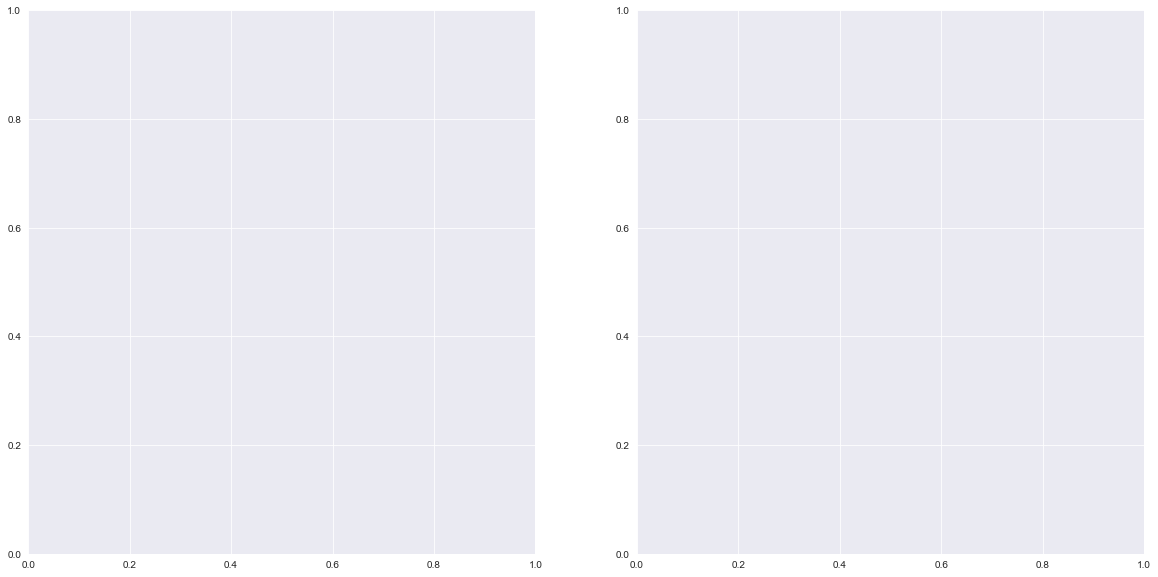

In [14]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [51]:
predicted = (model.predict(x_test) > 0.5).astype("int32")
predictions = predicted.reshape(1,-1)[0]

predictions[:15]

79/79 [==============================] - 16s 196ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [52]:
print(classification_report(y_test, predictions, target_names = ['O(Class 0)','R (Class 1)']))

              precision    recall  f1-score   support

  O(Class 0)       0.74      0.88      0.80      1401
 R (Class 1)       0.80      0.61      0.69      1112

    accuracy                           0.76      2513
   macro avg       0.77      0.75      0.75      2513
weighted avg       0.77      0.76      0.75      2513



In [18]:
cm = confusion_matrix(y_test,predictions)
cm

array([[1236,  165],
       [ 436,  676]], dtype=int64)

In [19]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

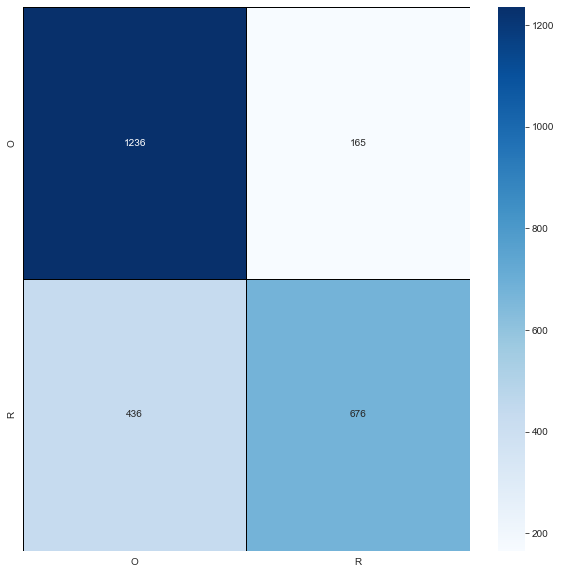

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [22]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### 올바르게 예측된 클래스 샘플

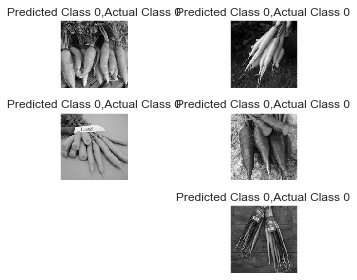

In [23]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### 올바르지 않게 예측된 클래스 샘플

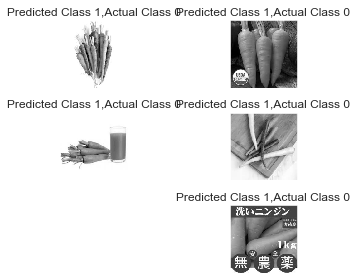

In [24]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [56]:
img_size = 150
def get_training_data(data_dir):
    data = [] 
    path = os.path.join(data_dir)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # 원하는 크기로 이미지 크기 변경
            data.append([resized_arr])
        except Exception as e:
            print(e)
    return np.array(data)

In [60]:
test = get_training_data('./testtest/')

len(test)

100

In [47]:
#test = []
#for feature, label in test:
#    test.append(feature)

In [61]:
test = np.array(test)/255

In [62]:
test= test.reshape(-1, img_size, img_size, 1)

In [63]:
predicted = (model.predict(test) > 0.5).astype("int32")
predictions = predicted.reshape(1,-1)[0]

predictions

4/4 [==============================] - 1s 144ms/step


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1])

In [64]:
final_score = 0 
for i in range(len(predictions)):
    if i < 50:
        if predictions[i] == 0:
            final_score += 1
    else:
        final_score +=1
print(final_score_score)

96


In [ ]:
# cnn도 